### Imports

In [3]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: c:\Users\nives\AllFolders\SML\mlfs-book
HopsworksSettings initialized!


In [199]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [5]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 15, 16, 19, 58, 813821)

### Connect to Hopsworks Feature Store </span>

In [6]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-15 16:20:28,000 INFO: Initializing external client
2025-11-15 16:20:28,000 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-15 16:20:28,699 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-15 16:20:29,558 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279175


### Download the model from Model Registry

In [7]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model_lagged_3",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-15 16:23:17,666 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/458511 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/102657 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/22528 elapsed<00:00 remaining<?

In [8]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='1.8544117E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Get Weather Forecast Features with Feature View



In [124]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

yesterday = today - datetime.timedelta(days = 1)
batch_data = weather_fg.filter(weather_fg.date > yesterday).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.20s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-16 00:00:00+00:00,2.50,0.0,10.829958,248.552200,Sollentuna
1,2025-11-18 00:00:00+00:00,-0.90,0.0,7.208994,272.862335,Sollentuna
2,2025-11-17 00:00:00+00:00,0.25,0.0,14.512064,316.004974,Sollentuna
3,2025-11-15 00:00:00+00:00,1.00,0.0,13.138765,260.537750,Sollentuna
4,2025-11-19 00:00:00+00:00,0.40,0.0,7.952660,5.194350,Sollentuna
5,2025-11-20 00:00:00+00:00,1.15,1.7,11.019764,51.632477,Sollentuna
6,2025-11-21 00:00:00+00:00,1.25,0.0,13.324863,1.548122,Sollentuna


### Get yesterday's PM25

In [125]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=3,
)

pm25_yesterday = air_quality_fg.filter(air_quality_fg.date > (yesterday-datetime.timedelta(days=1))).read()
pm25_yesterday

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.67s) 


,date,pm25,pm25_lagged_1,pm25_lagged_2,pm25_lagged_3,country,city,street,url
0,2025-11-14 00:00:00+00:00,10.0,10.0,10.0,10.0,Sweden,Sollentuna,ekmans-vag-11,https://api.waqi.info/feed/@13983


In [180]:
# Sort batch_data
batch_data = batch_data.sort_values(by=['date'], ignore_index=True)
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,pm25_lagged_1,pm25_lagged_2,pm25_lagged_3
0,2025-11-15 00:00:00+00:00,1.00,0.0,13.138765,260.537750,Sollentuna,24.549273,17.795561,18.796360,15.855515
1,2025-11-16 00:00:00+00:00,2.50,0.0,10.829958,248.552200,Sollentuna,15.855515,10.000000,10.000000,10.000000
2,2025-11-17 00:00:00+00:00,0.25,0.0,14.512064,316.004974,Sollentuna,17.795561,18.796360,15.855515,10.000000
3,2025-11-18 00:00:00+00:00,-0.90,0.0,7.208994,272.862335,Sollentuna,18.796360,15.855515,10.000000,10.000000
4,2025-11-19 00:00:00+00:00,0.40,0.0,7.952660,5.194350,Sollentuna,23.851845,24.549273,17.795561,18.796360
5,2025-11-20 00:00:00+00:00,1.15,1.7,11.019764,51.632477,Sollentuna,18.955034,23.851845,24.549273,17.795561
6,2025-11-21 00:00:00+00:00,1.25,0.0,13.324863,1.548122,Sollentuna,14.900851,18.955034,23.851845,24.549273


### Making the predictions

In [ ]:
#batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
#    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
#batch_data

In [184]:
# Just in case there are more rows retrieved
pm25_yesterday = pm25_yesterday.sort_values(by=['date'], ascending=False)

pm25_lagged_1 = [ pm25_yesterday.iloc[0]['pm25'] ]
pm25_lagged_2 = [ pm25_yesterday.iloc[0]['pm25_lagged_1'] ]
pm25_lagged_3 = [ pm25_yesterday.iloc[0]['pm25_lagged_2'] ]

result_vector = []

for i in range(batch_data.shape[0]):
    datapoint = pd.DataFrame()
    datapoint = batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']].iloc[i]
    datapoint['pm25_lagged_1'] = pm25_lagged_1[-1].astype('float32')
    datapoint['pm25_lagged_2'] = pm25_lagged_2[-1].astype('float32')
    datapoint['pm25_lagged_3'] = pm25_lagged_3[-1].astype('float32')
    datapoint = datapoint.to_frame().T
    datapoint = datapoint[['pm25_lagged_1', 'pm25_lagged_2', 'pm25_lagged_3', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']]

    pm25_predicted = retrieved_xgboost_model.predict(datapoint)
    result_vector.append(pm25_predicted[0])

    pm25_lagged_3.append(pm25_lagged_2[-1])
    pm25_lagged_2.append(pm25_lagged_1[-1])
    pm25_lagged_1.append(pm25_predicted[0])

batch_data['predicted_pm25'] = pd.DataFrame(result_vector)
batch_data['pm25_lagged_1'] = pd.DataFrame( pm25_lagged_1 )
batch_data['pm25_lagged_2'] = pd.DataFrame( pm25_lagged_2 )
batch_data['pm25_lagged_3'] = pd.DataFrame( pm25_lagged_3 )

batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,pm25_lagged_1,pm25_lagged_2,pm25_lagged_3
0,2025-11-15 00:00:00+00:00,1.00,0.0,13.138765,260.537750,Sollentuna,15.855515,10.000000,10.000000,10.000000
1,2025-11-16 00:00:00+00:00,2.50,0.0,10.829958,248.552200,Sollentuna,18.796360,15.855515,10.000000,10.000000
2,2025-11-17 00:00:00+00:00,0.25,0.0,14.512064,316.004974,Sollentuna,17.795561,18.796360,15.855515,10.000000
3,2025-11-18 00:00:00+00:00,-0.90,0.0,7.208994,272.862335,Sollentuna,24.549273,17.795561,18.796360,15.855515
4,2025-11-19 00:00:00+00:00,0.40,0.0,7.952660,5.194350,Sollentuna,23.851845,24.549273,17.795561,18.796360
5,2025-11-20 00:00:00+00:00,1.15,1.7,11.019764,51.632477,Sollentuna,18.955034,23.851845,24.549273,17.795561
6,2025-11-21 00:00:00+00:00,1.25,0.0,13.324863,1.548122,Sollentuna,14.900851,18.955034,23.851845,24.549273


In [185]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         7 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          7 non-null      float32                
 2   precipitation_sum            7 non-null      float32                
 3   wind_speed_10m_max           7 non-null      float32                
 4   wind_direction_10m_dominant  7 non-null      float32                
 5   city                         7 non-null      object                 
 6   predicted_pm25               7 non-null      float32                
 7   pm25_lagged_1                7 non-null      float32                
 8   pm25_lagged_2                7 non-null      float32                
 9   pm25_lagged_3                7 non-null      float32                
dtypes: dat

### Saving the predictions (for monitoring) to a Feature Group

In [186]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,pm25_lagged_1,pm25_lagged_2,pm25_lagged_3,street,country,days_before_forecast_day
0,2025-11-15 00:00:00+00:00,1.00,0.0,13.138765,260.537750,Sollentuna,15.855515,10.000000,10.000000,10.000000,ekmans-vag-11,Sweden,1
1,2025-11-16 00:00:00+00:00,2.50,0.0,10.829958,248.552200,Sollentuna,18.796360,15.855515,10.000000,10.000000,ekmans-vag-11,Sweden,2
2,2025-11-17 00:00:00+00:00,0.25,0.0,14.512064,316.004974,Sollentuna,17.795561,18.796360,15.855515,10.000000,ekmans-vag-11,Sweden,3
3,2025-11-18 00:00:00+00:00,-0.90,0.0,7.208994,272.862335,Sollentuna,24.549273,17.795561,18.796360,15.855515,ekmans-vag-11,Sweden,4
4,2025-11-19 00:00:00+00:00,0.40,0.0,7.952660,5.194350,Sollentuna,23.851845,24.549273,17.795561,18.796360,ekmans-vag-11,Sweden,5
5,2025-11-20 00:00:00+00:00,1.15,1.7,11.019764,51.632477,Sollentuna,18.955034,23.851845,24.549273,17.795561,ekmans-vag-11,Sweden,6
6,2025-11-21 00:00:00+00:00,1.25,0.0,13.324863,1.548122,Sollentuna,14.900851,18.955034,23.851845,24.549273,ekmans-vag-11,Sweden,7


In [187]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         7 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          7 non-null      float32                
 2   precipitation_sum            7 non-null      float32                
 3   wind_speed_10m_max           7 non-null      float32                
 4   wind_direction_10m_dominant  7 non-null      float32                
 5   city                         7 non-null      object                 
 6   predicted_pm25               7 non-null      float32                
 7   pm25_lagged_1                7 non-null      float32                
 8   pm25_lagged_2                7 non-null      float32                
 9   pm25_lagged_3                7 non-null      float32                
 10  street

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo.
Show it on github pages

2025-11-15 21:50:46,186 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



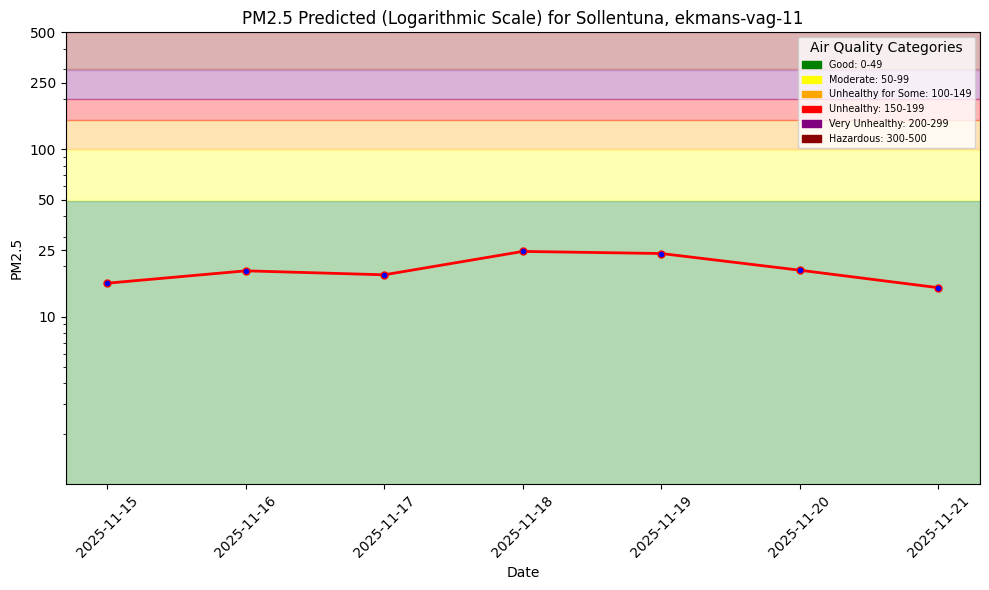

In [188]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [191]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions_lagged',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [192]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 7/7 | Elapsed Time: 00:02 | Remaining Time: 00:00


Launching job: aq_predictions_lagged_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279175/jobs/named/aq_predictions_lagged_1_offline_fg_materialization/executions
2025-11-15 21:55:58,951 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-15 21:56:02,119 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-15 21:57:36,136 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-15 21:57:36,331 INFO: Waiting for log aggregation to finish.
2025-11-15 21:57:45,328 INFO: Execution finished successfully.


(Job('aq_predictions_lagged_1_offline_fg_materialization', 'SPARK'), None)

In [193]:
# We will create a hindcast chart for only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.32s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,pm25_lagged_1,pm25_lagged_2,pm25_lagged_3,street,country,days_before_forecast_day
0,2025-11-15 00:00:00+00:00,1.0,0.0,13.138765,260.53775,Sollentuna,15.855515,10.0,10.0,10.0,ekmans-vag-11,Sweden,1


In [194]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=3)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.61s) 


,date,pm25,pm25_lagged_1,pm25_lagged_2,pm25_lagged_3,country,city,street,url
0,2024-08-11 00:00:00+00:00,9.0,12.0,15.0,16.0,Sweden,Sollentuna,ekmans-vag-11,https://api.waqi.info/feed/@13983
1,2024-06-10 00:00:00+00:00,9.0,11.0,18.0,15.0,Sweden,Sollentuna,ekmans-vag-11,https://api.waqi.info/feed/@13983
2,2023-10-21 00:00:00+00:00,9.0,9.0,9.0,8.0,Sweden,Sollentuna,ekmans-vag-11,https://api.waqi.info/feed/@13983
3,2025-07-30 00:00:00+00:00,20.0,21.0,20.0,21.0,Sweden,Sollentuna,ekmans-vag-11,https://api.waqi.info/feed/@13983
4,2024-12-05 00:00:00+00:00,27.0,19.0,8.0,36.0,Sweden,Sollentuna,ekmans-vag-11,https://api.waqi.info/feed/@13983
...,...,...,...,...,...,...,...,...,...
1110,2023-01-24 00:00:00+00:00,22.0,27.0,29.0,34.0,Sweden,Sollentuna,ekmans-vag-11,https://api.waqi.info/feed/@13983
1111,2024-03-10 00:00:00+00:00,11.0,15.0,27.0,39.0,Sweden,Sollentuna,ekmans-vag-11,https://api.waqi.info/feed/@13983
1112,2024-05-08 00:00:00+00:00,10.0,14.0,11.0,13.0,Sweden,Sollentuna,ekmans-vag-11,https://api.waqi.info/feed/@13983
1113,2025-11-13 00:00:00+00:00,8.0,8.0,8.0,8.0,Sweden,Sollentuna,ekmans-vag-11,https://api.waqi.info/feed/@13983


In [216]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = backfill_predictions_for_monitoring_lagged(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.52s) 
                       date  temperature_2m_mean  precipitation_sum  \
0 2025-11-12 00:00:00+00:00             7.737000                4.2   
1 2025-11-13 00:00:00+00:00             6.747416                3.0   
2 2025-11-14 00:00:00+00:00             0.701583                0.0   

   wind_speed_10m_max  wind_direction_10m_dominant        city  pm25_lagged_1  \
0           27.691935                   205.133698  Sollentuna           19.0   
1           21.304731                   268.332062  Sollentuna            8.0   
2           16.293728                   293.236481  Sollentuna           10.0   

   pm25_lagged_2  pm25_lagged_3  predicted_pm25  
0           14.0           17.0       19.394207  
1            8.0            8.0       12.019020  
2           10.0           10.0       12.878834  
                       date  temperature_2m_mean  precipitation_sum  \
0 2025-11-12 00:00:00+00:00      

Uploading Dataframe: 100.00% |██████████| Rows 3/3 | Elapsed Time: 00:02 | Remaining Time: 00:00


Launching job: aq_predictions_lagged_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279175/jobs/named/aq_predictions_lagged_1_offline_fg_materialization/executions
2025-11-15 22:43:22,383 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-15 22:43:25,773 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-15 22:45:06,354 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-15 22:45:06,534 INFO: Waiting for log aggregation to finish.
2025-11-15 22:45:15,230 INFO: Execution finished successfully.


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lagged_1,pm25_lagged_2,pm25_lagged_3,predicted_pm25,pm25,street,country,days_before_forecast_day
0,2025-11-12 00:00:00+00:00,7.737000,4.2,27.691935,205.133698,Sollentuna,19.0,14.0,17.0,19.394207,17.0,ekmans-vag-11,Sweden,1
1,2025-11-13 00:00:00+00:00,6.747416,3.0,21.304731,268.332062,Sollentuna,8.0,8.0,8.0,12.019020,8.0,ekmans-vag-11,Sweden,1
2,2025-11-14 00:00:00+00:00,0.701583,0.0,16.293728,293.236481,Sollentuna,10.0,10.0,10.0,12.878834,10.0,ekmans-vag-11,Sweden,1


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

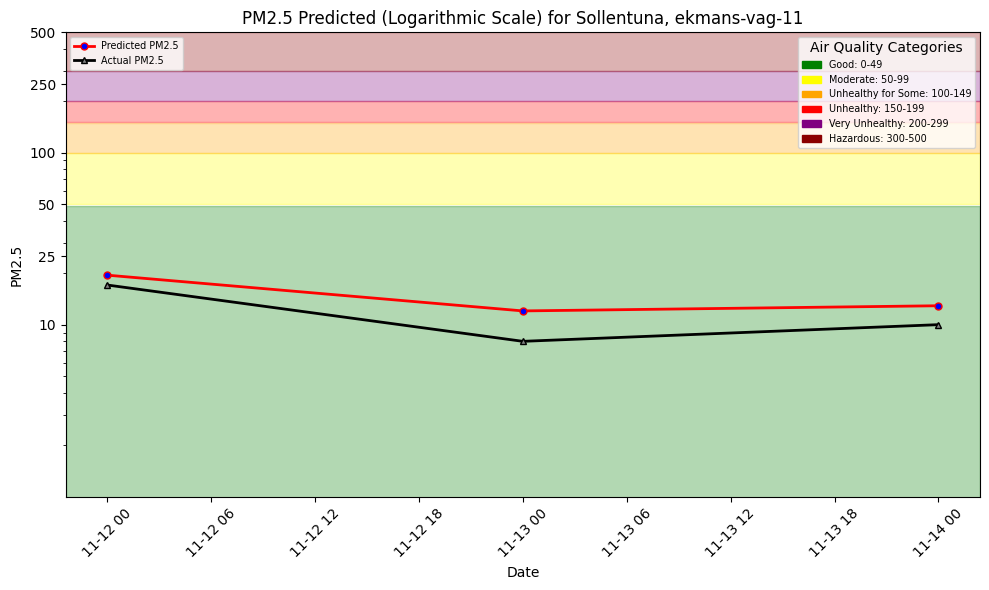

In [217]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [218]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading c:\Users\nives\AllFolders\SML\mlfs-book/docs/air-quality/assets/img/pm25_forecast.png: 0.000%|      …

Uploading c:\Users\nives\AllFolders\SML\mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day.png: 0.000%| …

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1279175/settings/fb/path/Resources/airquality
